<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant', 'MAMS', 'mpqa']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'


def create_quad_plot(data_df: pd.DataFrame) -> List[List[plt.Axes]]:
  fig, axes = plt.subplots(2,2,figsize=(15,10))
  dataset_list_order = [['Restaurant', 'MAMS'],['Laptop', 'mpqa']]
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for row_index, dataset_name_list in enumerate(dataset_list_order):
    for col_index, dataset_name in enumerate(dataset_name_list):
      df = data_df[data_df['Dataset']==dataset_name]
      axes[row_index][col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd',
                                                y='Score', hue='Model',
                                                x='Metric', data=df,
                                                hue_order=HUE_ORDER,
                                                order=METRIC_ORDER,
                                                ax=axes[row_index][col_index])
      axes[row_index][col_index].set_title(f'{dataset_name}')
      if row_index == 0:
        axes[row_index][col_index].set_xlabel('')
      if col_index == 1:
        axes[row_index][col_index].set_ylabel('')
      if row_index != 0 or col_index == 1:
        axes[row_index][col_index].get_legend().remove()
      else:
        axes[row_index][col_index].legend(ncol=7, borderaxespad=0.,
                                          bbox_to_anchor=(0.18, 1.1), 
                                          loc='lower left')
  return axes

def create_triple_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,3,figsize=(22.5, 5))
  dataset_list_order = ['Restaurant', 'MAMS', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.9, 1.1), loc='lower left')
  return axes

def get_data(cwr: bool = False) -> Dict:
  results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['mpqa', 'Restaurant', 'Laptop', 'MAMS']
  dataset_name_mapper = {f'{name}_contextualized': name for name in dataset_names}
  if cwr:
    dataset_names = [f'{name}_contextualized' for name in dataset_names]
  split_names = ['Validation', 'Test']
  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (LEX NEG)':
      model_url = base_url + '/mtl/cd_lextag'
    for dataset_name in dataset_names:
      for split_name in split_names:
        if split_name == 'Test':
          if dataset_name == 'MAMS' or dataset_name == 'MAMS_contextualized':
            result_url = model_url + f'/{dataset_name}/test.conll'
          else:
            result_url = model_url + f'/{dataset_name.lower()}/test.conll'
        elif split_name == 'Validation':
          if dataset_name == 'MAMS' or dataset_name == 'MAMS_contextualized':
            result_url = model_url + f'/{dataset_name}/dev.conll'
          else:
            result_url = model_url + f'/{dataset_name.lower()}/dev.conll'
        for run_number in range(5):
          with tempfile.TemporaryDirectory() as temp_dir:
            temp_fp = Path(temp_dir, 'temp_file.txt')
            with temp_fp.open('w') as temp_file:
              temp_file.write(requests.get(result_url).text)
            f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=True)
            f1_a_recall, f1_a_precision, f1_a = f1_a
            f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False)
            f1_i_recall, f1_i_precision, f1_i = f1_i
            pos_filter_name = 'POS'
            neu_filter_name = 'NEU'
            neg_filter_name = 'NEG'
            if dataset_name == 'mpqa' or dataset_name == 'mpqa_contextualized':
              pos_filter_name = 'positive'
              neu_filter_name = 'neutral'
              neg_filter_name = 'negative'

            f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=pos_filter_name)
            f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
            f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=neu_filter_name)
            f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
            f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment=neg_filter_name) 
            f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
            f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                        metric_func=f1_score, 
                                                        average='macro')
            acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                        metric_func=accuracy_score)
            if cwr:
              results_df_dict['CWR'].append(True)
            else:
              results_df_dict['CWR'].append(False)
            results_df_dict['Model'].append(model_name)
            if dataset_name in dataset_name_mapper:
              results_df_dict['Dataset'].append(dataset_name_mapper[dataset_name])
            else:
              results_df_dict['Dataset'].append(dataset_name)
            results_df_dict['Split'].append(split_name)
            results_df_dict['Run'].append(run_number)
            results_df_dict['F1-a'].append(f1_a)
            results_df_dict['F1-a-R'].append(f1_a_recall)
            results_df_dict['F1-a-P'].append(f1_a_precision)
            results_df_dict['F1-i'].append(f1_i)
            results_df_dict['F1-i-R'].append(f1_i_recall)
            results_df_dict['F1-i-P'].append(f1_i_precision)
            results_df_dict['F1-i-pos'].append(f1_i_pos)
            results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
            results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
            results_df_dict['F1-i-neg'].append(f1_i_neg)
            results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
            results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
            results_df_dict['F1-i-neu'].append(f1_i_neu)
            results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
            results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
            results_df_dict['F1-s'].append(f1_s)
            results_df_dict['Acc-s'].append(acc_s)
  return results_df_dict

# Significant Testing methods
from scipy import stats
def one_tailed_p_value(scores_1: List[float], scores_2: List[float], 
                       assume_normal: bool) -> float:
  '''
  :param scores_1: The scores e.g. list of accuracy values that reprsent one 
                    model/methods results (multiple scores can come from running 
                    the same model/method over different random seeds and/or 
                    dataset splits).
  :param scores_2: Same as `scores_1` but coming from a different method/model
  :param assume_normal: If the the scores are assumed to come from a normal 
                        distribution. See the following guide by 
                        `Dror and Reichart 2018 <https://arxiv.org/pdf/1809.01448.pdf>`_
                        to know if your metric/scores can be assumed to be normal or 
                        not. The test used when the scores are normal is the 
                        Welch’s t-test. When not normal it is the 
                        Wilcoxon signed-rank test.
  :returns: The p-value of a one-tailed test to determine if `scores_1` is 
            better than `scores_2`.
  '''
  p_value = -1.0
  if assume_normal:
    stat_result = stats.ttest_ind(scores_1, scores_2, equal_var=False, 
                                  nan_policy='raise')
    # one tailed hence why divided by 2
    p_value = stat_result.pvalue / 2
    # This is to take into account if the other is better
    if stat_result.statistic < 0:
      p_value = 1 - p_value
  else:
    stat_result = stats.wilcoxon(scores_1, scores_2, correction=False, 
                                  alternative='greater', zero_method='wilcox')
    p_value = stat_result.pvalue
  if p_value == -1.0:
    raise ValueError('P-Value was not calculated for these scores: '
                      f'score_1 {score_1} and scores_2 {scores_2} where '
                      f'the assumption of normality is {assume_normal}')
  return p_value

def create_p_value_results(metric_results: pd.DataFrame, 
                           p_value_threshold: float = 0.05,
                           keep_raw_p_value: bool = False
                           ) ->Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
  stats_metrics = metric_results['Metric'].unique().tolist()
  stats_datasets = metric_results['Dataset'].unique().tolist()
  stats_model_names = metric_results['Model'].unique().tolist()
  # Store whether or not one model is significantly better than another
  dataset_metric_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
  for dataset in stats_datasets:
    dataset_df = metric_results[metric_results['Dataset']==dataset]
    for metric in stats_metrics:
      metric_df = dataset_df[dataset_df['Metric']==metric]
      for model in stats_model_names:
        for compare_model in stats_model_names:
          if compare_model == model:
            dataset_metric_model_stats[dataset][metric][model][compare_model] = 0
          else:
            model_results = metric_df[metric_df['Model']==model]['Score'].tolist()
            compare_model_results = metric_df[metric_df['Model']==compare_model]['Score'].tolist()
            if metric == 'Acc-s':
              assume_normal = True
            else:
              assume_normal = False
            p_value = one_tailed_p_value(model_results, compare_model_results, 
                                        assume_normal=assume_normal)
            significant = 0
            if p_value <= p_value_threshold:
              significant = 1
            if keep_raw_p_value:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = p_value
            else:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = significant
  return dataset_metric_model_stats
  
def create_stats_heatmap(stats_dict: Dict[str, Dict[str, Dict[str, Dict[str, int]]]],
                         metric: str) -> List[List[plt.Axes]]:
  colorbar_values = [0, 1]
  cmap = sns.color_palette("hls", 2)
  vmin = 0
  vmax = 1
  dataset_list_order = [['Restaurant', 'MAMS'], ['Laptop', 'mpqa']]
  fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True, sharex=True)
  
  for row_index, dataset_list in enumerate(dataset_list_order):
    for col_index, dataset in enumerate(dataset_list):
      model_comparisons = stats_dict[dataset][metric]
      ax = axes[row_index][col_index]
      ax = sns.heatmap(pd.DataFrame(model_comparisons), cmap=cmap,linewidths=.5, 
                       ax=ax, vmin=vmin, vmax=vmax)
      ax.set_title(dataset)
      cb = ax.collections[-1].colorbar
      cb.set_ticks(colorbar_values)
      cb.set_ticklabels(['Not Significant', 'Significant'])
  return axes


def p_value_compared_to_stl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  stl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model == 'STL':
          continue
        stl_p_values.append(compare['STL'])
        datasets.append(dataset)
        metrics.append(metric)
        models.append(model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': stl_p_values})
  
def p_value_compared_to_mtl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  mtl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model != 'STL':
          continue
        for compare_model in compare:
          if compare_model == 'STL':
            continue
          mtl_p_values.append(compare[compare_model])
          datasets.append(dataset)
          metrics.append(metric)
          models.append(compare_model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': mtl_p_values})

# Evaluating Targeted Sentiment Analysis (TSA) Systems
In this notebook we evaluate the different TSA models where each model is made up of the following Neural Network (NN) architecture:  

![Neural Network architecture](https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/resources/architecture.png "Neural Network architecture")

This is a similar architecture to that used in [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf). The architecture is two stacked Bi-LSTM's with a skip connection layer from the embedding to the second Bi-LSTM. The general learning objective is to improve the Span F1 measure on extracting the targets and their respective sentiment from the text. The models created here are the standard Single Task Leaning (STL) which does not make use of the `Auxilary CRF Tagger` and the Multi Task Learning (MTL) which uses the `Auxilary CRF Tagger` to learn an additional task at the same time as the TSA.


There are six different MTL models being evaluated:

1. **MTL (CD)** - Which uses the [Conan Doyle stories Morante and Blanco, 2012](https://www.aclweb.org/anthology/S12-1035.pdf) to learn Negation Scope and Cue detection.
2. **MTL (SFU)** - Which uses the [SFU a review corpus Konstantinova et al. 2012](http://www.lrec-conf.org/proceedings/lrec2012/pdf/533_Paper.pdf) to learn Negation Scope and Cue detection.
3. **MTL (SPEC)** - Which uses the [SFU a review corpus Konstantinova et al. 2012](http://www.lrec-conf.org/proceedings/lrec2012/pdf/533_Paper.pdf) to learn Speculation Scope and Cue detection.
4. **MTL (UPOS)** - Which uses the [Streusle review corpus Schneider and Smith 2015](https://www.aclweb.org/anthology/N15-1177/) to learn Universal Part Of Speech.
5. **MTL (DR)** - Which uses the [Streusle review corpus Schneider and Smith 2015](https://www.aclweb.org/anthology/N15-1177/) to learn Dependency Relation labels.
6. **MTL (LEX)** - Which uses the [Streusle review corpus Schneider and Smith 2015](https://www.aclweb.org/anthology/N15-1177/) to learn strong and weak Multi Word Expressions (MWE) as well as their associated lexial and supersense category. See the `LEXTAG` column in the [Streusle CoNLL-U-Lex format.](https://github.com/nert-nlp/streusle/blob/master/CONLLULEX.md)

The TSA datasets that the models will be evaluated are the **Laptop** and **Restaurant** review datasets taken from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) which originally come from the SemEval [2014](https://www.aclweb.org/anthology/S14-2004/), [2015](https://www.aclweb.org/anthology/S15-2082/), and [2016](https://www.aclweb.org/anthology/S16-1002/) aspect based sentiment analysis task. We took the dataset from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) so that our results are directly comparable as their dataset statistics are different from the original datasets, which is most likely due to transforming the dataset into CONLL format which is token and not span based as the original datasets are. We are also going to use the **MAMS** restuarant datastes from [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654.pdf). Finally the **MPQA** dataset as well.

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

The main metric for TSA is *F1-i*. The other metrics will probe the models performance in the relevant areas to allow better understanding of these models.

## Embeddings

For both the STL and MTL models we will evauluate them on two different embeddings:
1. [300 dimension GloVe embeddings.](https://nlp.stanford.edu/projects/glove/)
2. Contextualised Word Representations (CWR).

Therefore this notebook will first look at the GloVe embedding models and then the CWR models. Then we will compare the two.

# GloVe Results

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Split
5. CWR - Whether the embeddings are CWR or not. Not here would mean we are using the GloVe embeddings.
6. Metric
7. Score


In [3]:
results_df = pd.DataFrame(get_data())
not_metric_cols = ['Model', 'Dataset', 'Split', 'Run', 'CWR']
metric_cols = [col_name for col_name in results_df.columns.tolist() 
               if col_name not in not_metric_cols]
results_df = pd.melt(results_df, id_vars=not_metric_cols, value_vars=metric_cols, 
                     var_name='Metric', value_name='Score')
test_results_df = results_df[results_df['Split']=='Test']
val_results_df = results_df[results_df['Split']=='Validation']
results_df.head()

,Model,Dataset,Split,Run,CWR,Metric,Score
0,STL,mpqa,Validation,0,False,F1-a,0.159710
1,STL,mpqa,Validation,1,False,F1-a,0.215289
2,STL,mpqa,Validation,2,False,F1-a,0.197026
3,STL,mpqa,Validation,3,False,F1-a,0.202658
4,STL,mpqa,Validation,4,False,F1-a,0.230994


## F1-i

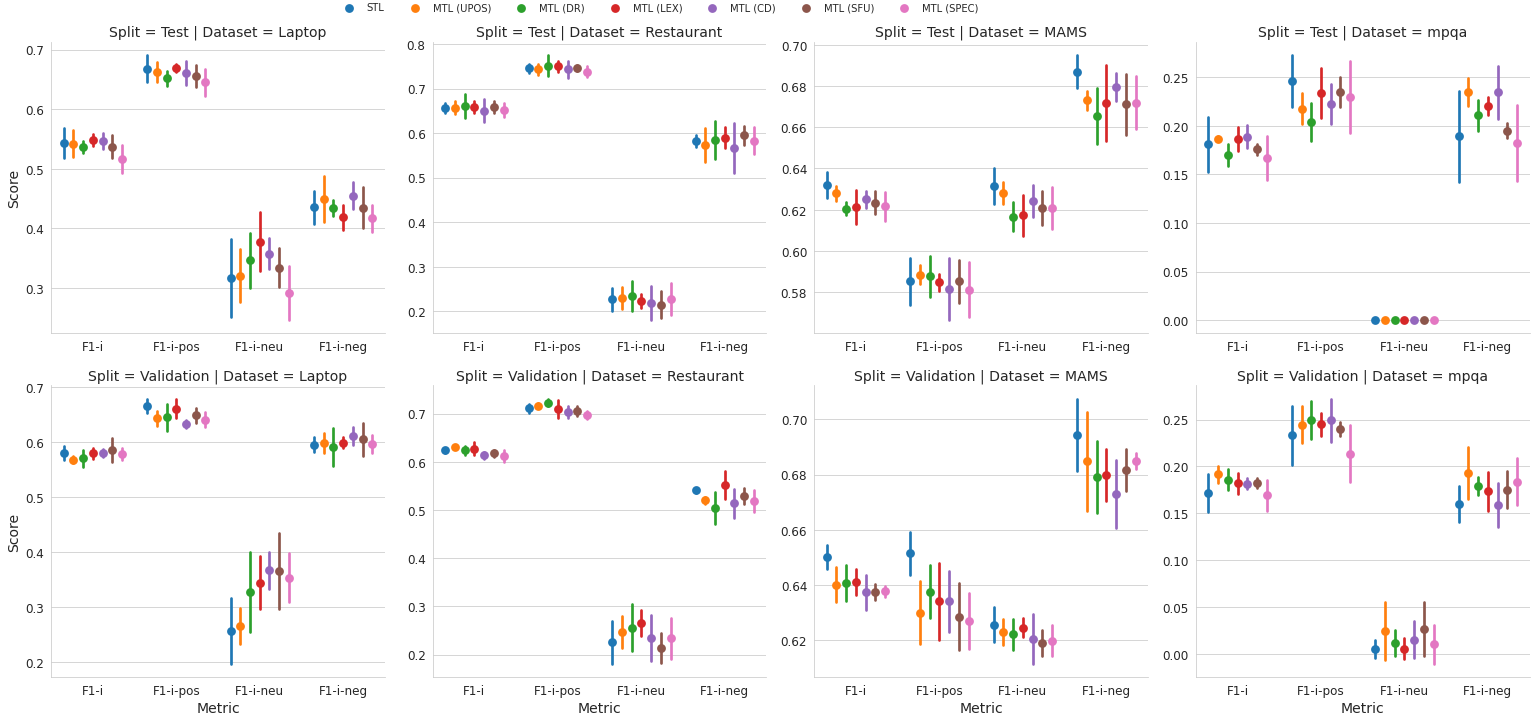

In [33]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = results_df[results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=results_df, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-a

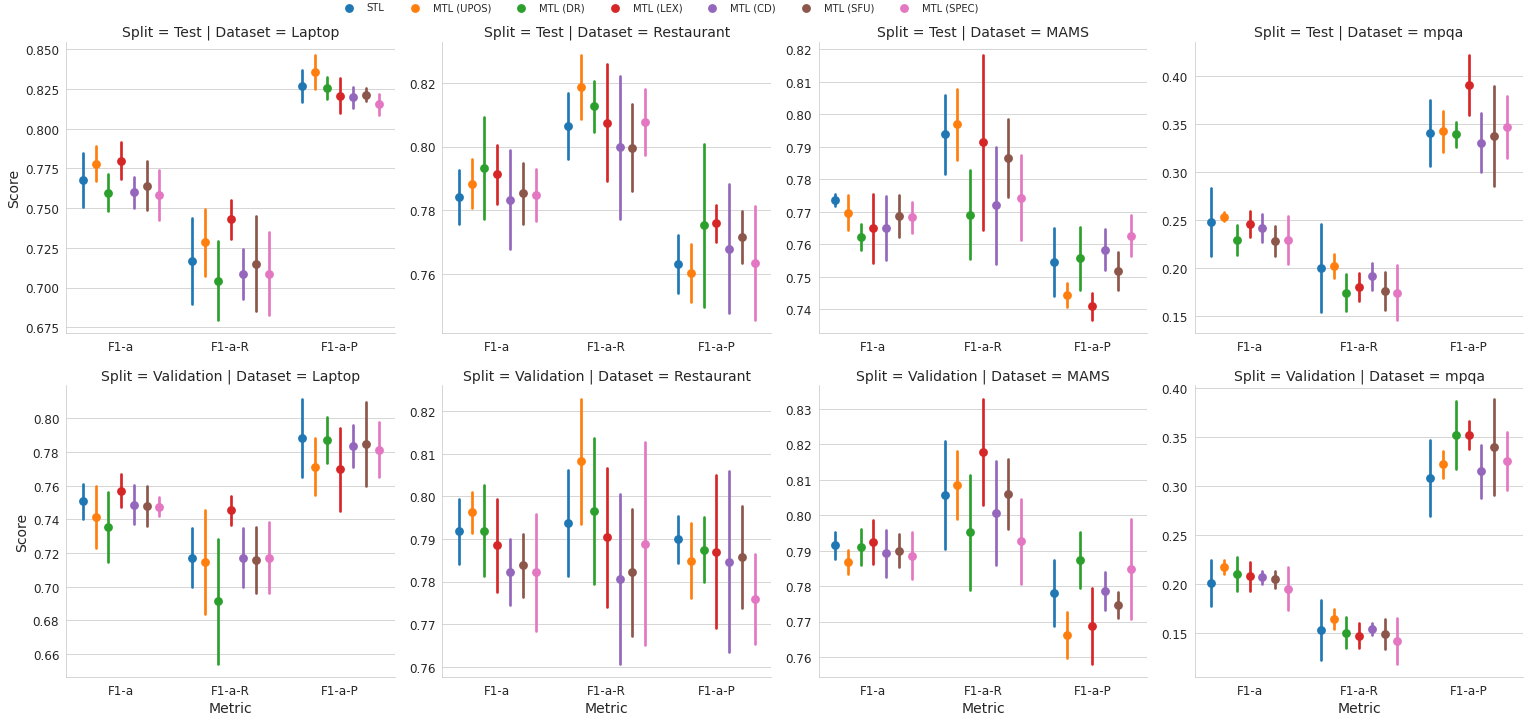

In [34]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = results_df[results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-s and Acc-s

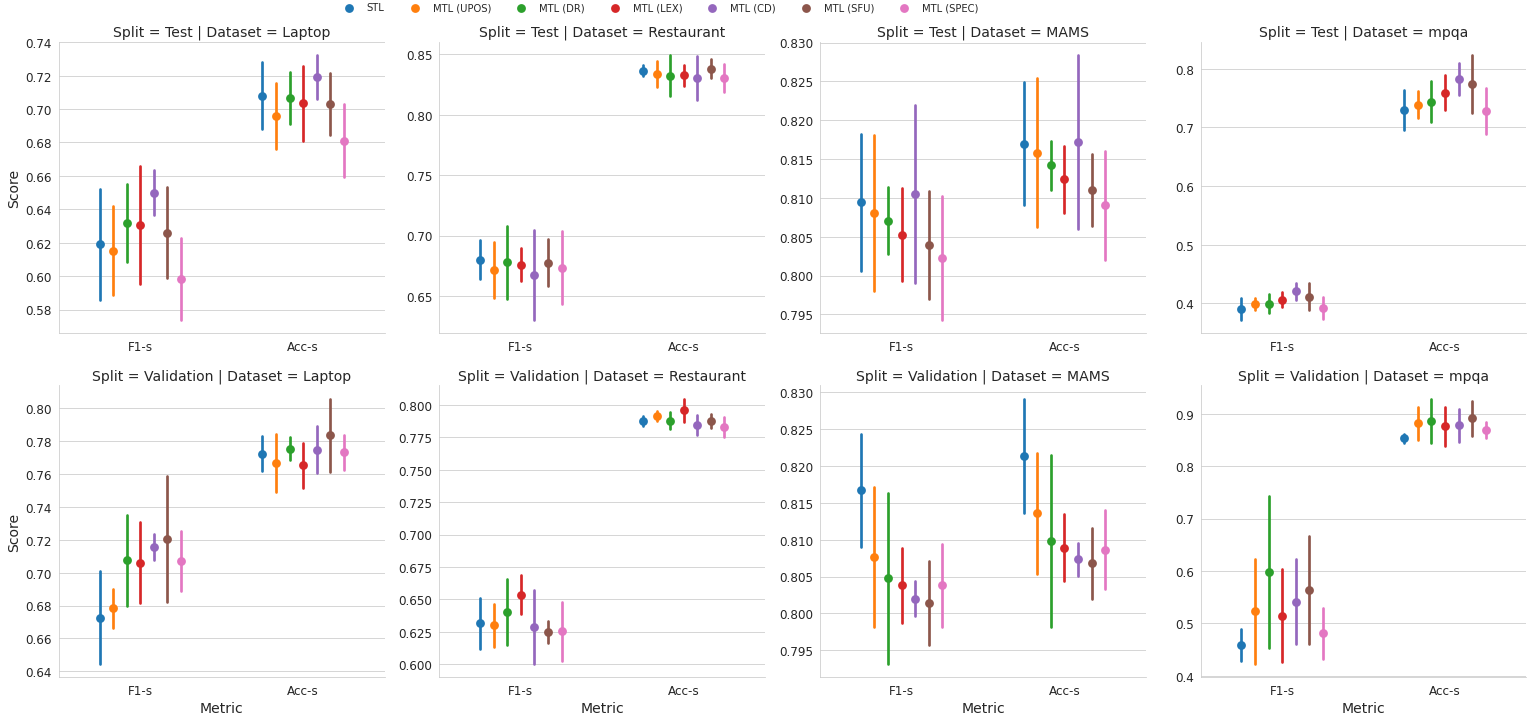

In [35]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = results_df[results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## Headline Metric

These are the metrics that are reported most:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

Thus we fit these into a single plot for each dataset.

### Validation Results

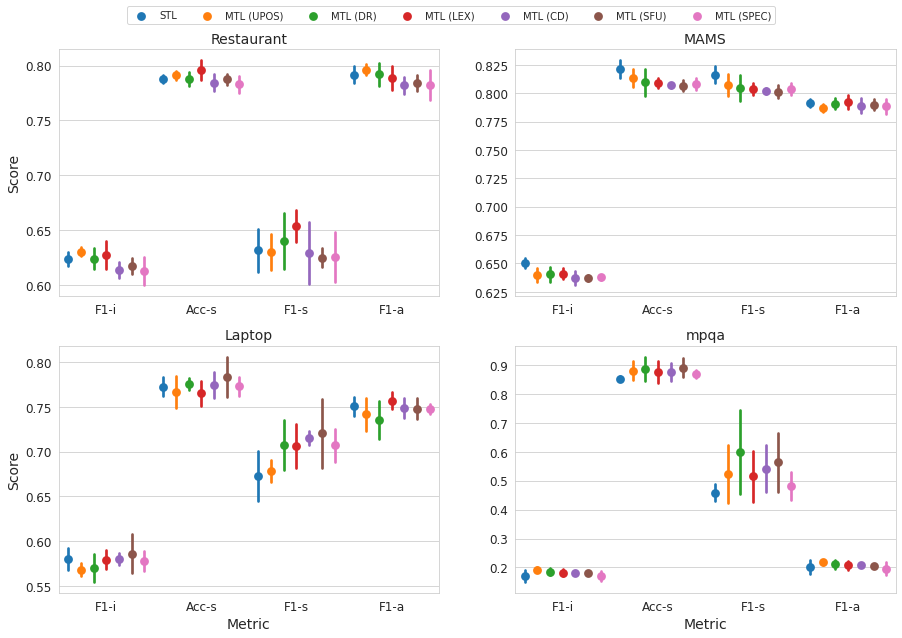

In [36]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = results_df[results_df['Metric'].isin(headline_metric_order)]
validation_headline_results = headline_results[headline_results['Split']=='Validation']
_ = create_quad_plot(validation_headline_results)

### Test Results

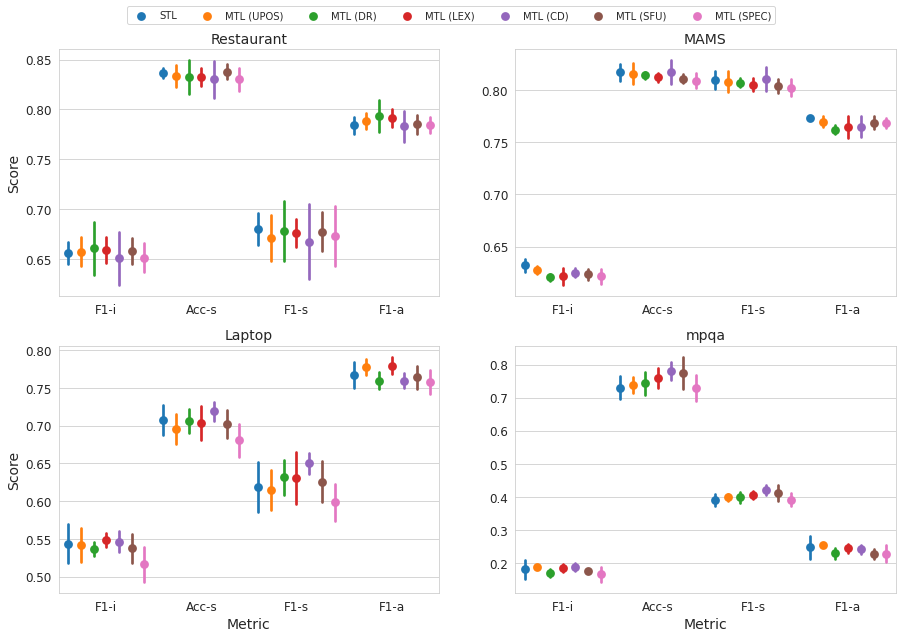

In [37]:
test_headline_results = headline_results[headline_results['Split']=='Test']
_ = create_quad_plot(test_headline_results)

## Statistical Significance

As we can see from the above headline results the STL models tends to perform comparable to all of the other MTL models. Therefore here we show the P-Values to determine how confident we are the STL model is better than the MTL models:

### Validation

In [64]:
validation_p_value_results = create_p_value_results(validation_headline_results, keep_raw_p_value=True)
validation_p_value_results = p_value_compared_to_mtl(validation_p_value_results)
pd.pivot_table(validation_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.6057    0.6800  ...      0.5508      0.3054
       MAMS          0.0096    0.0712  ...      0.0148      0.1017
       Restaurant    0.2321    0.5189  ...      0.1711      0.8963
       mpqa          0.9009    0.9065  ...      0.9431      0.9251
F1-a   Laptop        0.3429    0.1125  ...      0.4464      0.1726
       MAMS          0.3429    0.5536  ...      0.2501      0.0690
       Restaurant    0.1125    0.3429  ...      0.1125      0.8875
       mpqa          0.5536    0.7499  ...      0.0690      0.8875
F1-i   Laptop        0.4464    0.1125  ...      0.4464      0.0398
       MAMS          0.0216    0.0216  ...      0.0216      0.0216
       Restaurant    0.0398    0.2501  ...      0.0398      0.9310
       mpqa          0.7499    0.7499  ...      0.2501      0.9310
F1-s   Laptop        0.9784    0.8875  ...      0.9310      0.4464
       MAMS          0.0216    0.0398  ...      0.0216      0.1726
       Restaurant    0.2501    0.7499  ...      0.3429      0.4464
       mpqa          0.9310    0.8875  ...      0.9602      0.7499

[16 rows x 6 columns]

### Test

In [44]:
test_p_value_results = create_p_value_results(test_headline_results, keep_raw_p_value=True)
test_p_value_results = p_value_compared_to_mtl(test_p_value_results)
pd.pivot_table(test_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.8050    0.4580  ...      0.0544      0.2105
       MAMS          0.5107    0.2676  ...      0.0853      0.4281
       Restaurant    0.2657    0.3270  ...      0.1749      0.3241
       mpqa          0.9767    0.7045  ...      0.4720      0.6500
F1-a   Laptop        0.2501    0.2501  ...      0.1726      0.9602
       MAMS          0.0690    0.0216  ...      0.1125      0.1125
       Restaurant    0.4464    0.8875  ...      0.5536      0.8274
       mpqa          0.2501    0.1726  ...      0.0690      0.4464
F1-i   Laptop        0.5536    0.3429  ...      0.1125      0.2501
       MAMS          0.0690    0.0216  ...      0.0690      0.1125
       Restaurant    0.4464    0.7499  ...      0.2501      0.6571
       mpqa          0.5536    0.2501  ...      0.1125      0.4464
F1-s   Laptop        0.9310    0.8274  ...      0.1125      0.3429
       MAMS          0.5536    0.2501  ...      0.1125      0.5536
       Restaurant    0.2501    0.4464  ...      0.4464      0.1726
       mpqa          0.9310    0.8875  ...      0.4464      0.8274

[16 rows x 6 columns]

# Contextualized Word Representation (CWR) results

All of the results prior are for models that have used the 300D GloVe embeddings. The results now use the domain specific CWR ELMO Transformer embeddings, of which the MPQA uses the non-domain specific CWR embeddings.

In [4]:
cwr_results_df = pd.DataFrame(get_data(cwr=True))
not_metric_cols = ['Model', 'Dataset', 'Split', 'Run', 'CWR']
metric_cols = [col_name for col_name in cwr_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
cwr_results_df = pd.melt(cwr_results_df, id_vars=not_metric_cols, value_vars=metric_cols, 
                         var_name='Metric', value_name='Score')
cwr_test_results_df = cwr_results_df[cwr_results_df['Split']=='Test']
cwr_val_results_df = cwr_results_df[cwr_results_df['Split']=='Validation']
cwr_results_df.head()

,Model,Dataset,Split,Run,CWR,Metric,Score
0,STL,mpqa,Validation,0,True,F1-a,0.333863
1,STL,mpqa,Validation,1,True,F1-a,0.333333
2,STL,mpqa,Validation,2,True,F1-a,0.345161
3,STL,mpqa,Validation,3,True,F1-a,0.332779
4,STL,mpqa,Validation,4,True,F1-a,0.324059


## F1-i

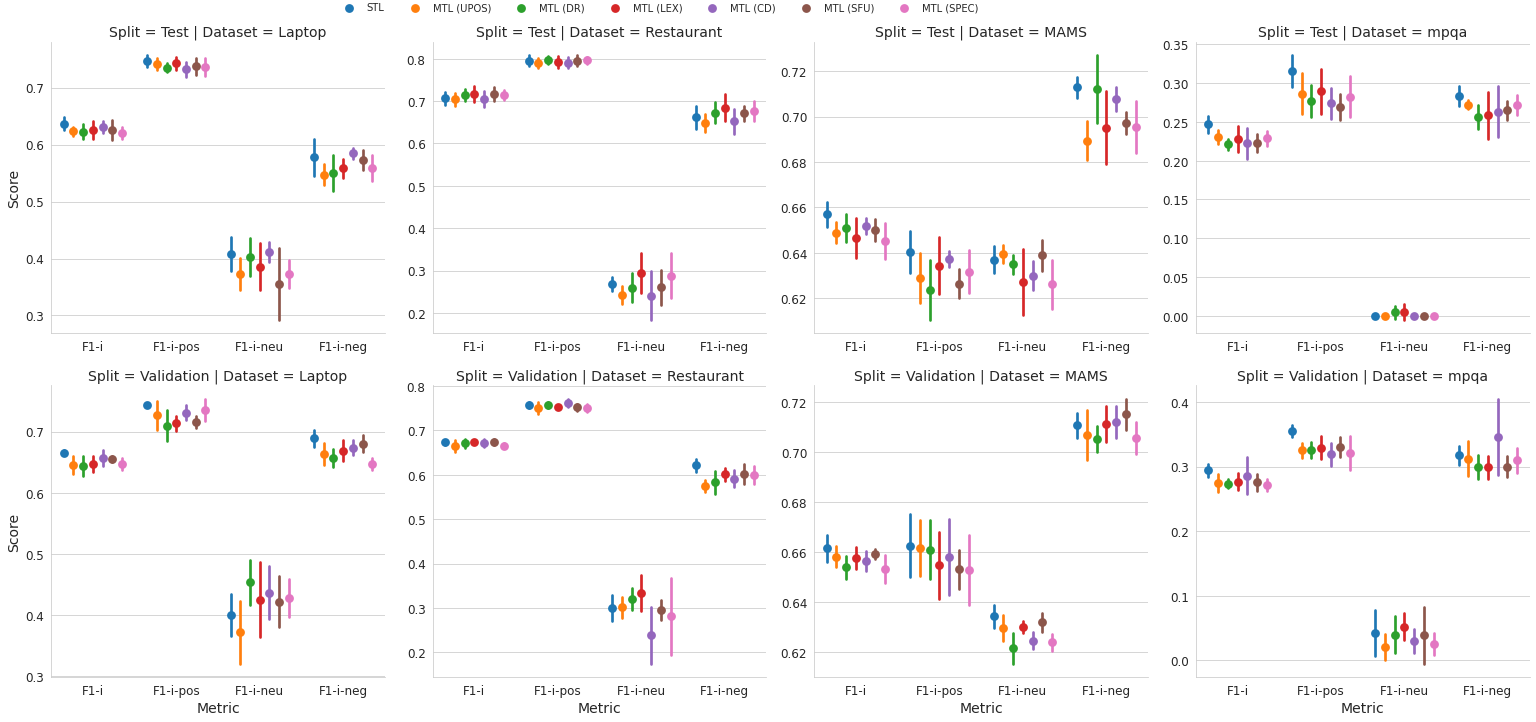

In [5]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = cwr_results_df[cwr_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=cwr_results_df, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-a

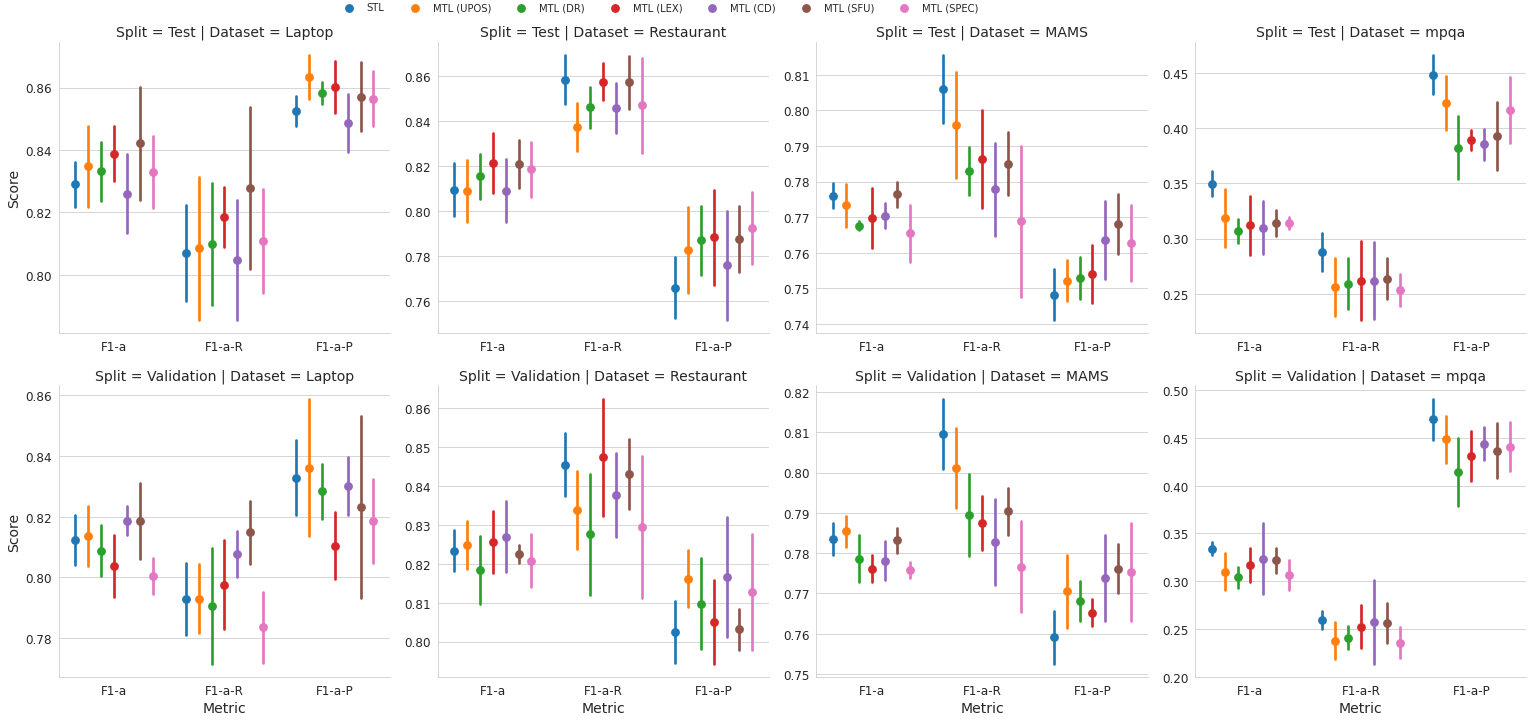

In [7]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = cwr_results_df[cwr_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## F1-s and Acc-s

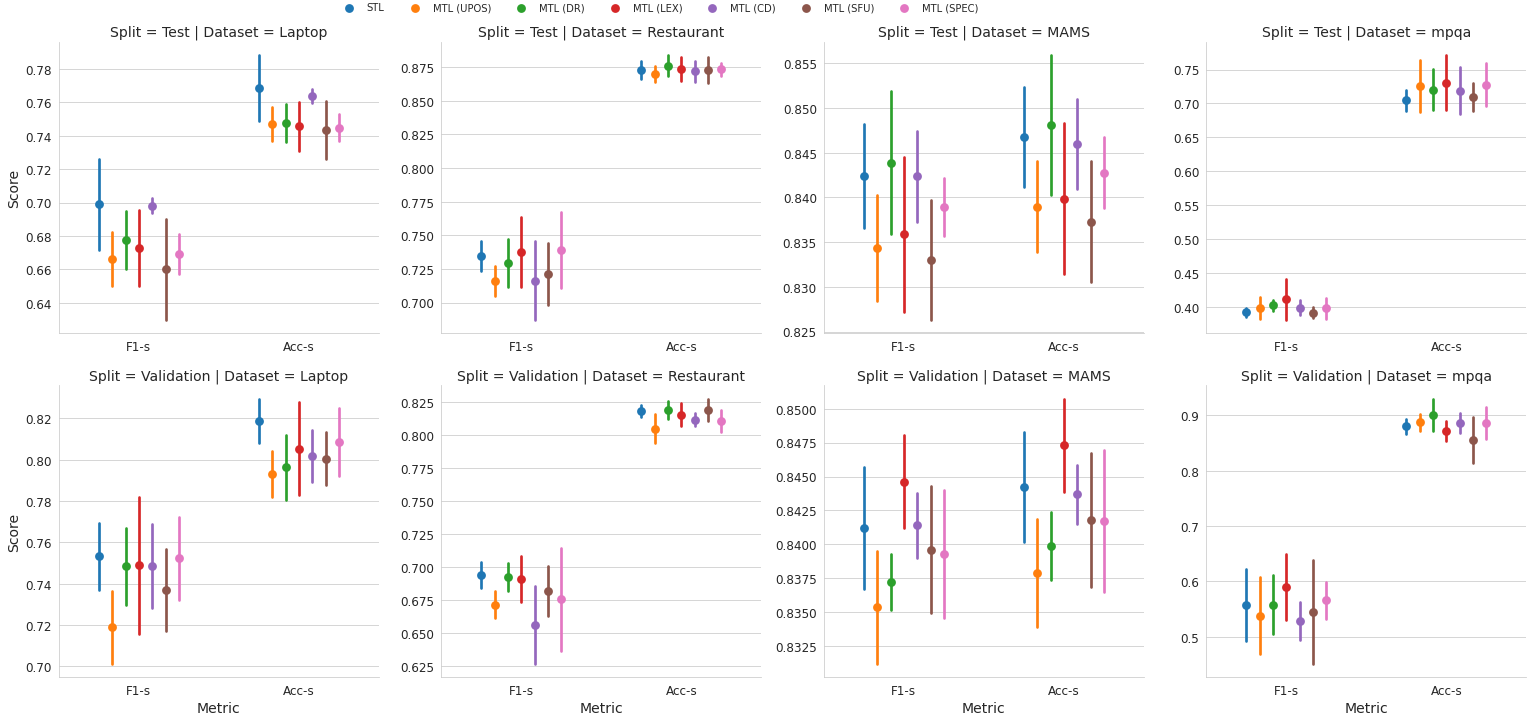

In [8]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = cwr_results_df[cwr_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

## Headline Metric

These are the metrics that are reported most:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

Thus we fit these into a single plot for each dataset.

### Validation Results

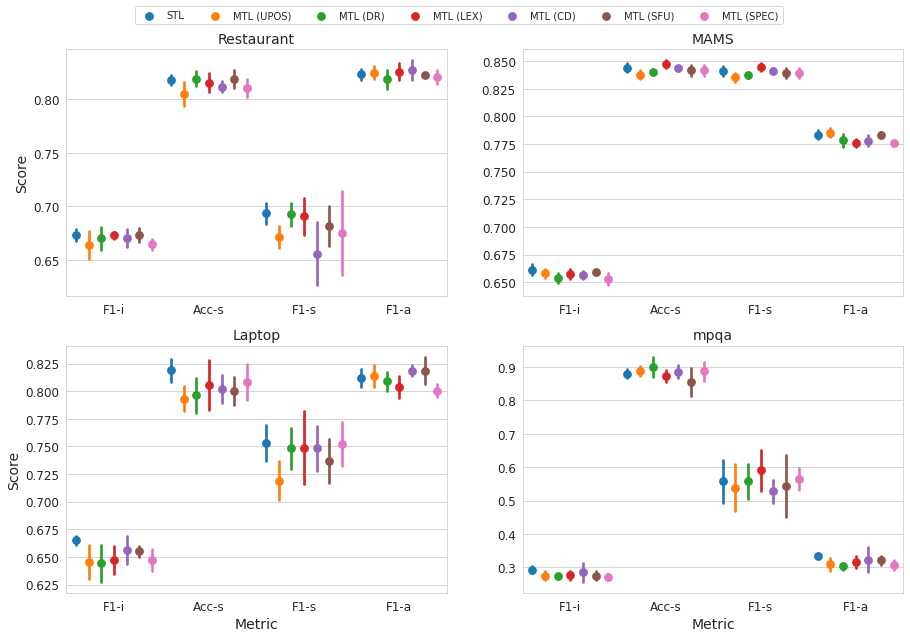

In [9]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
cwr_headline_results = cwr_results_df[cwr_results_df['Metric'].isin(headline_metric_order)]
cwr_validation_headline_results = cwr_headline_results[cwr_headline_results['Split']=='Validation']
_ = create_quad_plot(cwr_validation_headline_results)

### Test Results

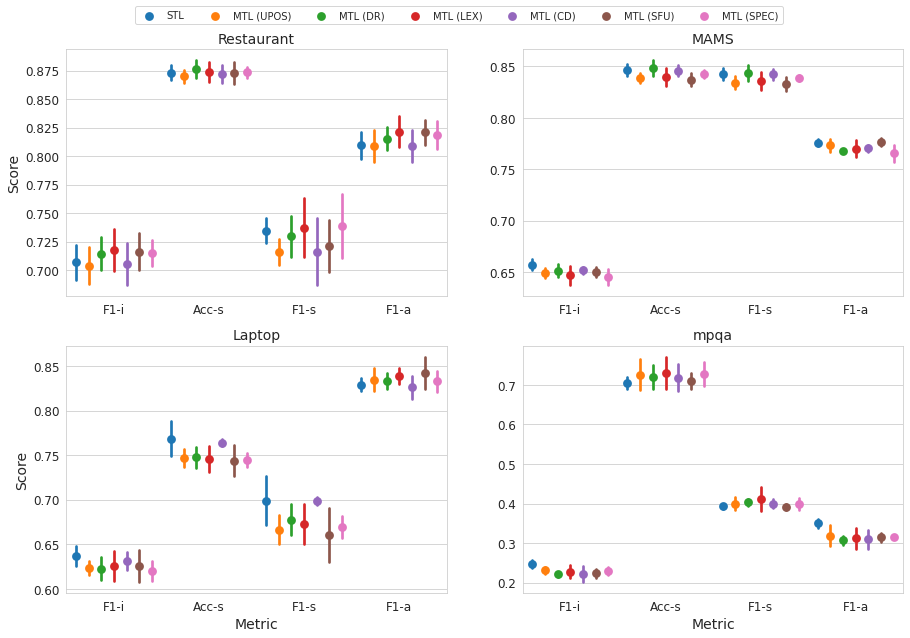

In [10]:
cwr_test_headline_results = cwr_headline_results[cwr_headline_results['Split']=='Test']
_ = create_quad_plot(cwr_test_headline_results)

## Statistical Significance

As we can see from the above headline results the STL models tends to perform comparable to all of the other MTL models. Therefore here we show the P-Values to determine how confident we are the STL model is better than the MTL models:

### Validation

In [58]:
cwr_validation_p_value_results = create_p_value_results(cwr_validation_headline_results, 
                                                        keep_raw_p_value=True)
cwr_validation_p_value_results = p_value_compared_to_mtl(cwr_validation_p_value_results)
pd.pivot_table(cwr_validation_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.0367    0.0242  ...      0.1664      0.0053
       MAMS          0.4090    0.0559  ...      0.2352      0.0283
       Restaurant    0.0524    0.6149  ...      0.0853      0.0381
       mpqa          0.6980    0.8746  ...      0.6610      0.7513
F1-a   Laptop        0.8875    0.1726  ...      0.0690      0.7499
       MAMS          0.1125    0.1125  ...      0.0216      0.7499
       Restaurant    0.8274    0.0398  ...      0.1726      0.6571
       mpqa          0.4464    0.0216  ...      0.0216      0.0216
F1-i   Laptop        0.1125    0.0690  ...      0.0216      0.0398
       MAMS          0.1125    0.0398  ...      0.0216      0.1125
       Restaurant    0.4464    0.1726  ...      0.0690      0.1726
       mpqa          0.4464    0.0216  ...      0.0398      0.0216
F1-s   Laptop        0.3429    0.3429  ...      0.5536      0.0216
       MAMS          0.6571    0.1125  ...      0.5536      0.0216
       Restaurant    0.0216    0.4464  ...      0.1726      0.0216
       mpqa          0.4464    0.2501  ...      0.5536      0.2501

[16 rows x 6 columns]

### Test

In [31]:
cwr_test_p_value_results = create_p_value_results(cwr_test_headline_results, 
                                                  keep_raw_p_value=True)
cwr_test_p_value_results = p_value_compared_to_mtl(cwr_test_p_value_results)
pd.pivot_table(cwr_test_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.3366    0.0552  ...      0.0359      0.0495
       MAMS          0.4181    0.6078  ...      0.1409      0.0368
       Restaurant    0.4147    0.7223  ...      0.5457      0.2405
       mpqa          0.7512    0.8026  ...      0.8839      0.8276
F1-a   Laptop        0.3429    0.7499  ...      0.8274      0.8274
       MAMS          0.0398    0.0216  ...      0.0398      0.2501
       Restaurant    0.5536    0.8875  ...      0.9310      0.4464
       mpqa          0.0216    0.0216  ...      0.0216      0.0216
F1-i   Laptop        0.1726    0.1125  ...      0.0690      0.1125
       MAMS          0.1726    0.0690  ...      0.0398      0.1125
       Restaurant    0.4464    0.6571  ...      0.8875      0.3429
       mpqa          0.0398    0.0216  ...      0.0398      0.0398
F1-s   Laptop        0.4464    0.2501  ...      0.0398      0.0398
       MAMS          0.5536    0.6571  ...      0.1125      0.0690
       Restaurant    0.1125    0.1726  ...      0.7499      0.0216
       mpqa          0.8875    0.9310  ...      0.6571      0.6571

[16 rows x 6 columns]

# Comparing GloVe and CWR model results

Below we plot the GloVe and CWR model results for the **F1-i** metric:

Validation:

In [55]:
all_results = pd.concat([results_df, cwr_results_df])
all_f1_i_results = all_results[all_results['Metric']=='F1-i']
all_validation_results = all_f1_i_results[all_f1_i_results['Split']=='Validation']
pd.pivot_table(all_validation_results, values='Score', index='Model', 
               columns=['Dataset', 'CWR'], aggfunc=mean_std)

Dataset           Laptop                ...          mpqa              
CWR                False         True   ...         False         True 
Model                                   ...                            
MTL (CD)    57.99 (0.69)  65.64 (1.26)  ...  18.14 (0.58)  28.60 (2.82)
MTL (DR)    57.02 (1.53)  64.42 (1.64)  ...  18.57 (1.13)  27.35 (0.72)
MTL (LEX)   57.92 (1.08)  64.73 (1.30)  ...  18.18 (1.10)  27.67 (1.29)
MTL (SFU)   58.62 (2.19)  65.52 (0.52)  ...  18.23 (0.55)  27.53 (1.30)
MTL (SPEC)  57.80 (1.10)  64.72 (0.97)  ...  16.94 (1.66)  27.15 (0.92)
MTL (UPOS)  56.82 (0.71)  64.55 (1.53)  ...  19.16 (0.89)  27.49 (1.38)
STL         57.97 (1.24)  66.51 (0.43)  ...  17.16 (2.07)  29.39 (0.95)

[7 rows x 8 columns]

Test:

In [13]:
all_test_results = all_f1_i_results[all_f1_i_results['Split']=='Test']
pd.pivot_table(all_test_results, values='Score', index='Model', 
               columns=['Dataset', 'CWR'], aggfunc=mean_std)

Dataset           Laptop                ...          mpqa              
CWR                False         True   ...         False         True 
Model                                   ...                            
MTL (CD)    54.65 (1.37)  63.11 (0.99)  ...  18.88 (1.17)  22.25 (2.00)
MTL (DR)    53.67 (0.94)  62.29 (1.32)  ...  17.03 (1.12)  22.09 (0.70)
MTL (LEX)   54.85 (0.99)  62.55 (1.66)  ...  18.66 (1.22)  22.74 (1.68)
MTL (SFU)   53.73 (1.93)  62.61 (1.79)  ...  17.60 (0.57)  22.30 (1.19)
MTL (SPEC)  51.65 (2.32)  62.03 (1.14)  ...  16.70 (2.26)  22.86 (0.98)
MTL (UPOS)  54.17 (2.26)  62.35 (0.77)  ...  18.70 (0.25)  23.05 (0.88)
STL         54.37 (2.56)  63.70 (1.14)  ...  18.11 (2.83)  24.66 (1.07)

[7 rows x 8 columns]

An interesting finding when comparing the two embeddings is that the CWR makes large gains on all datasets apart from the **MAMS** where the difference is marginal, for example for the **STL** model the difference is **2.5** and **1.14** F1 score for the test and validation splits. In comparison the largest difference between the CWR and GloVe embeddings for the **STL** model is **9.33** for the **Laptop** test split and **12.23** for the **mpqa** validation split.

# Extras

Below we show the statistical significance between each model. These heatmaps show whether or not the model in the X-axis is significantly better than the model on the Y-axis with a confidence of at least 95%.

## Statistical Tests for all the GloVe models

These are all of the significance results for the GloVe based models.

### F1-i

Validation:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


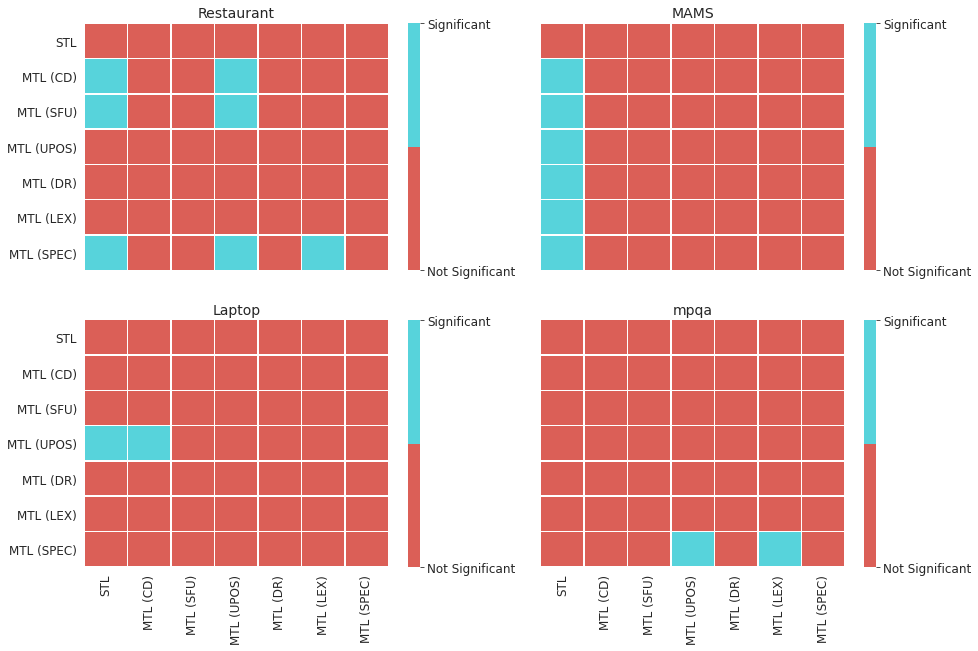

In [45]:
validation_p_value_results = create_p_value_results(validation_headline_results, 
                                                    p_value_threshold=0.05)
_ = create_stats_heatmap(validation_p_value_results, metric='F1-i')

Test:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


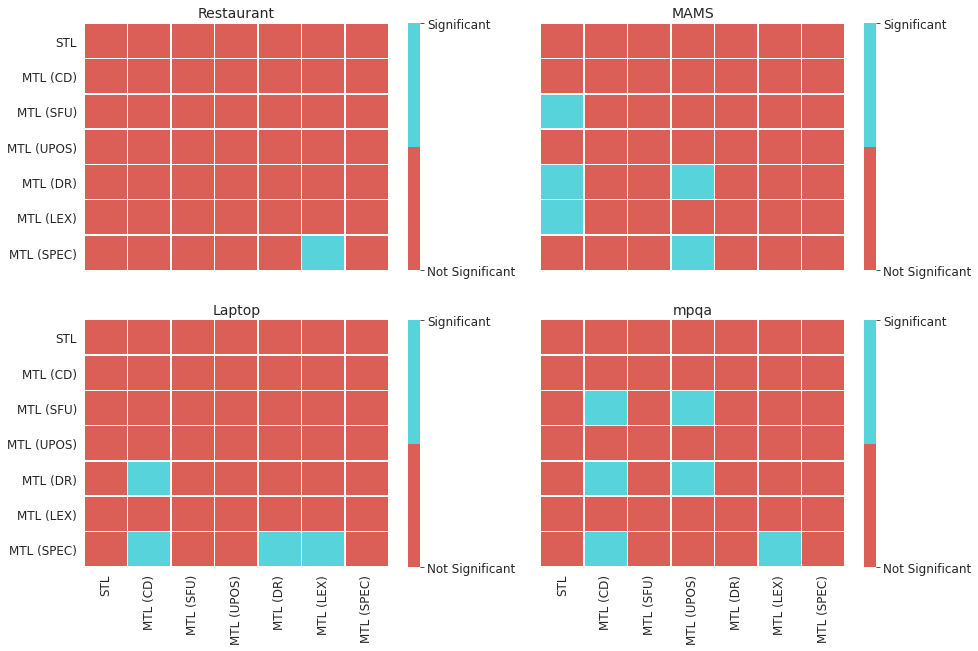

In [46]:
test_p_value_results = create_p_value_results(test_headline_results, 
                                              p_value_threshold=0.05)
_ = create_stats_heatmap(test_p_value_results, metric='F1-i')

#### F1-a

Validation:

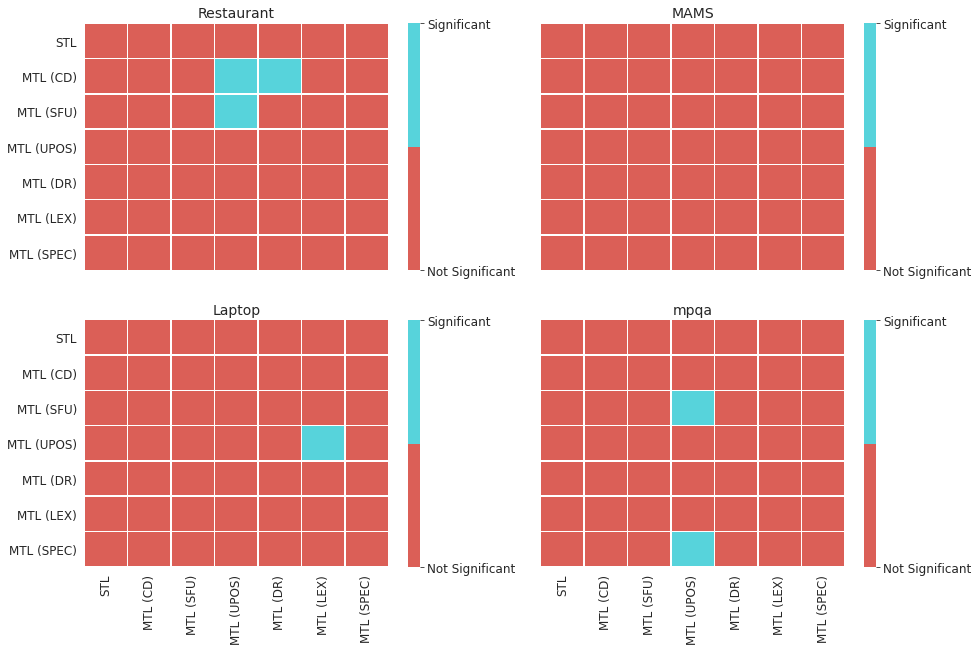

In [47]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-a')

Test:

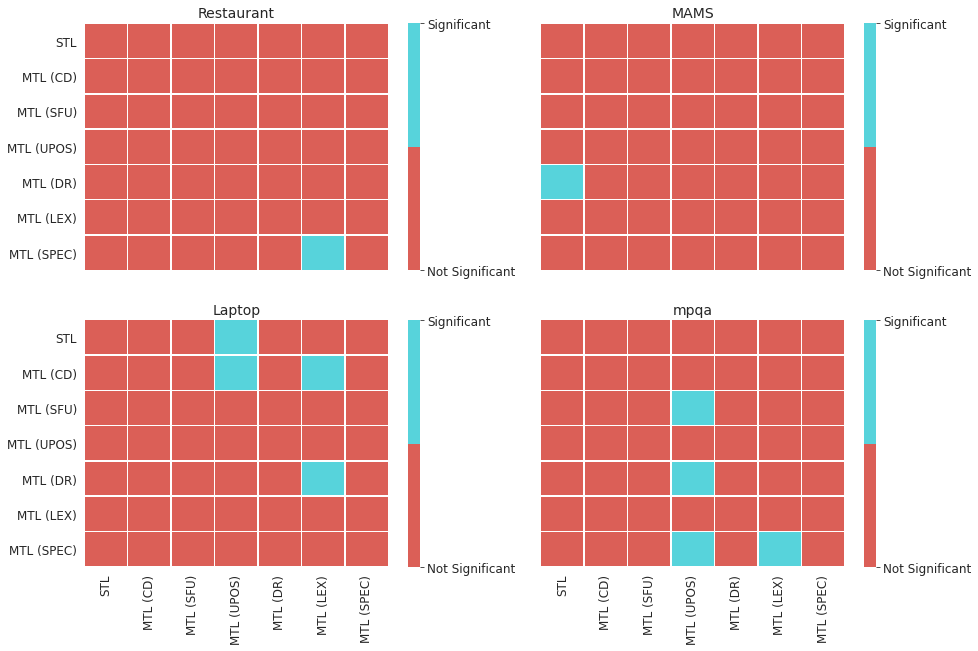

In [48]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-a')

#### F1-s

Validation:

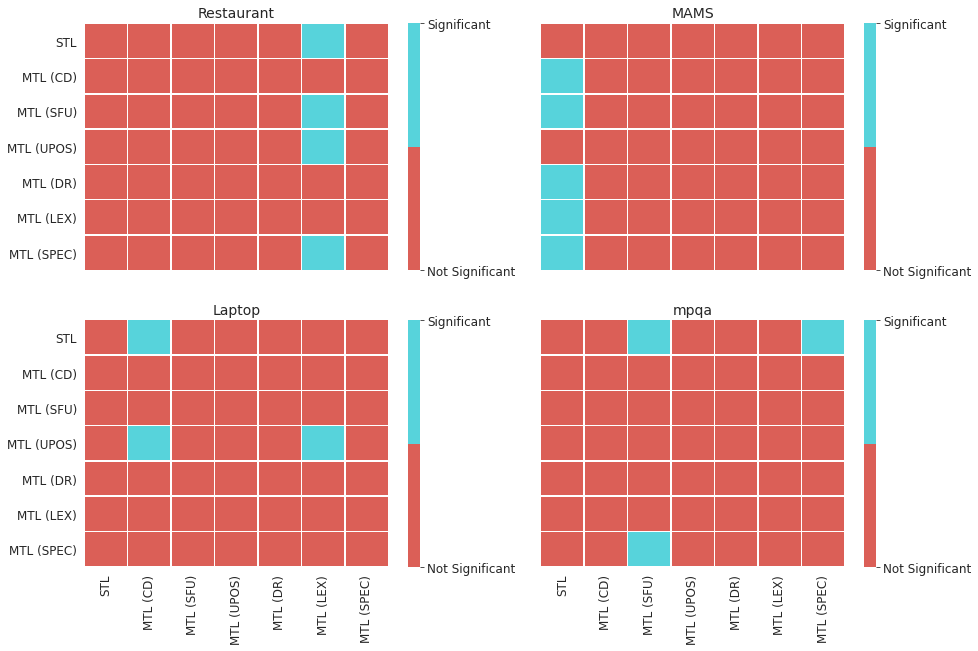

In [49]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-s')

Test:

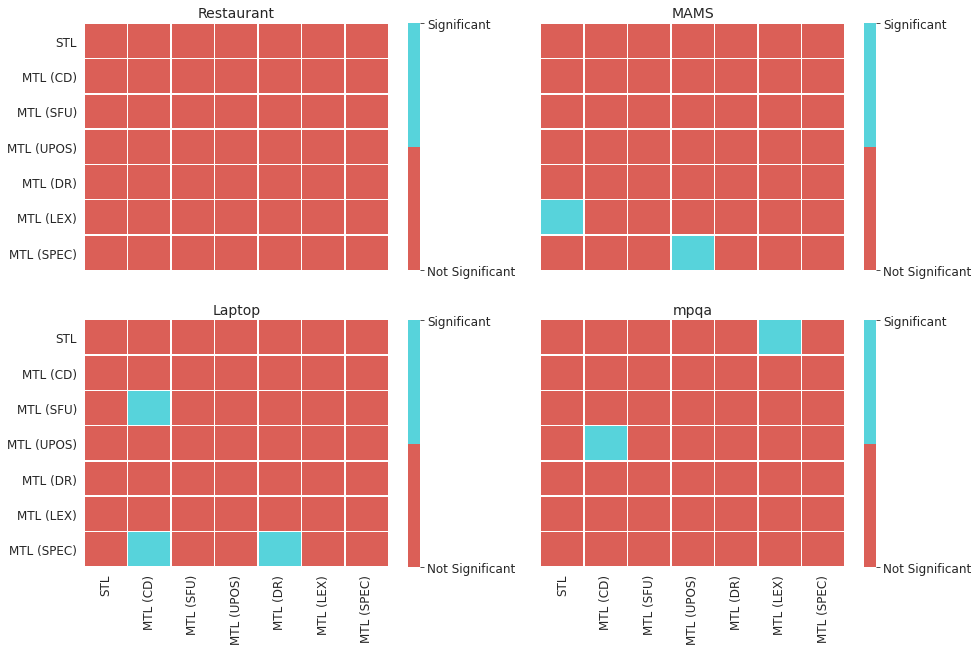

In [50]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-s')

#### Acc-s

Validation:

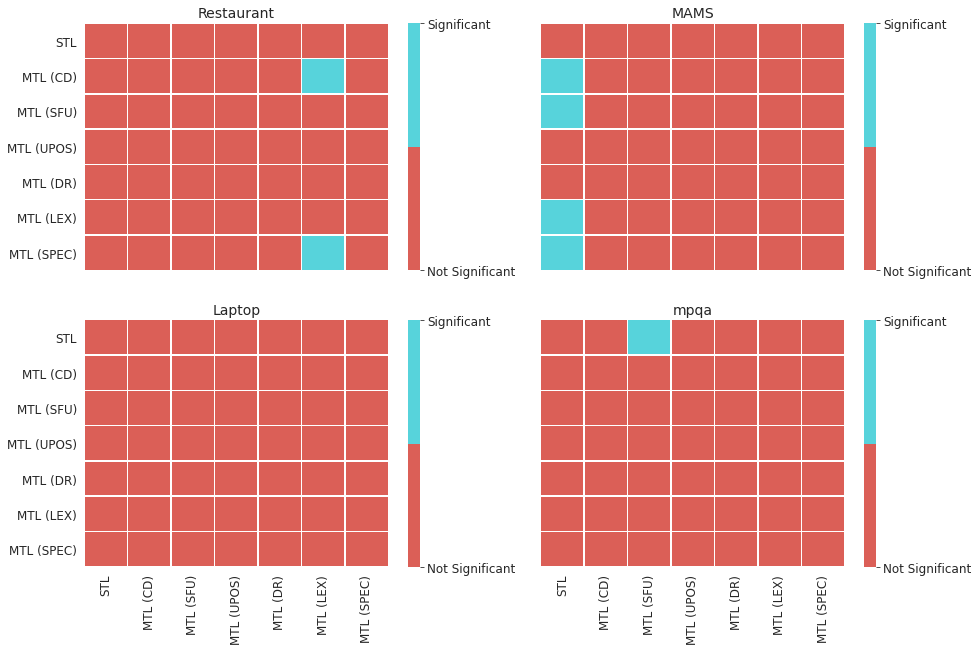

In [51]:
_ = create_stats_heatmap(validation_p_value_results, metric='Acc-s')

Test:

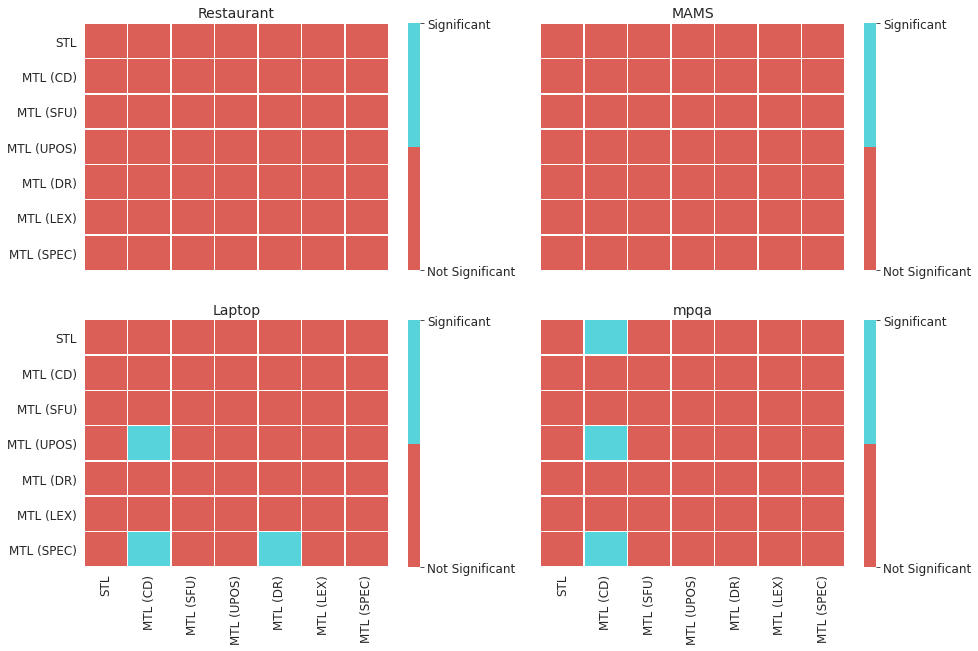

In [52]:
_ = create_stats_heatmap(test_p_value_results, metric='Acc-s')

## Statistical Tests for all the CWR models

These are all of the significance results for the CWR based models.

### F1-i

Validation:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


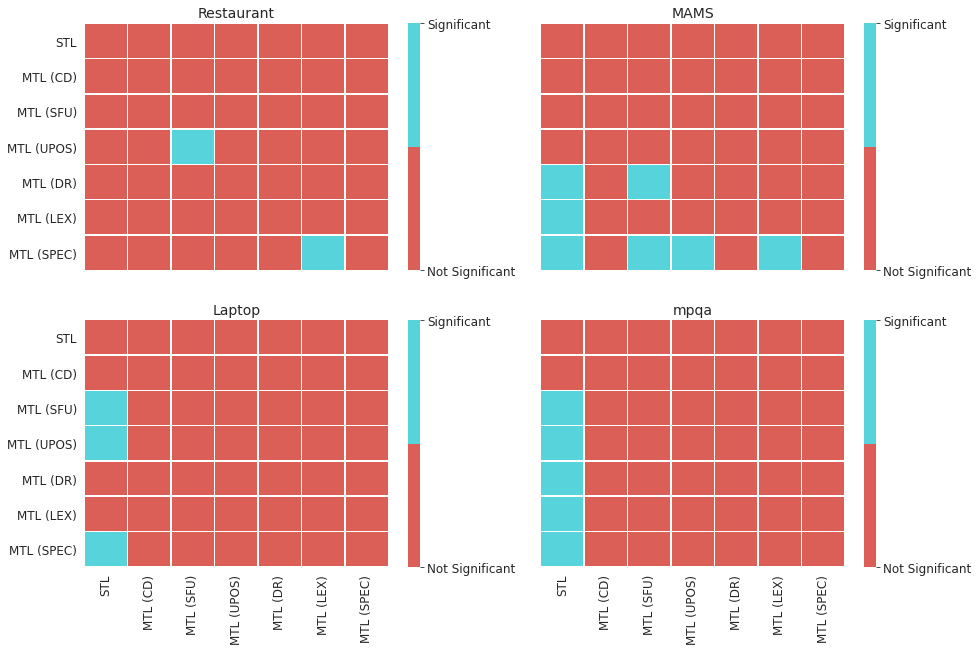

In [21]:
cwr_validation_p_value_results = create_p_value_results(cwr_validation_headline_results, 
                                                        p_value_threshold=0.05)
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-i')

Test:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


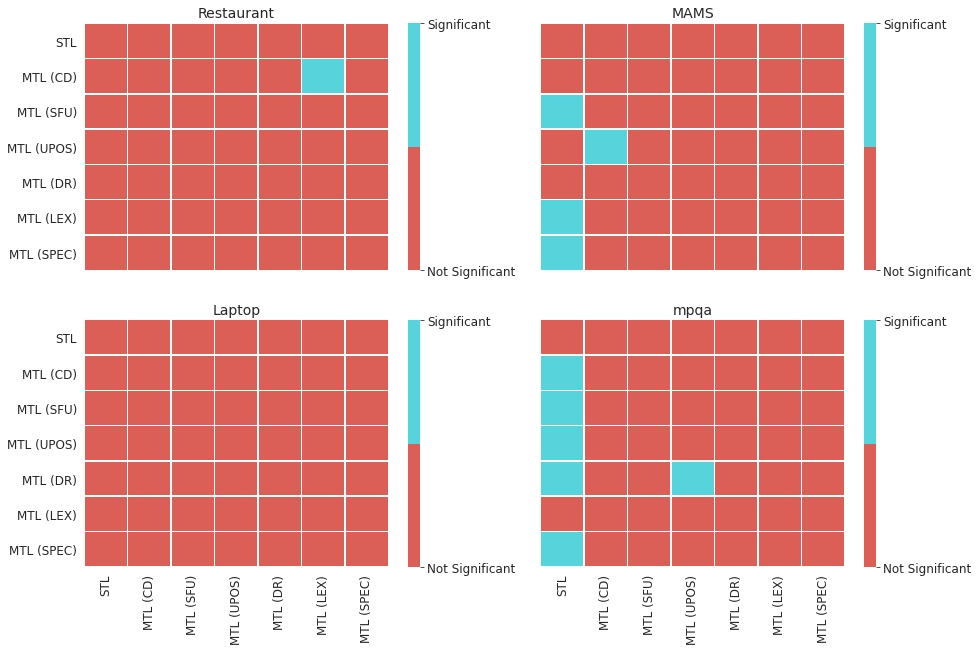

In [22]:
cwr_test_p_value_results = create_p_value_results(cwr_test_headline_results, 
                                                  p_value_threshold=0.05)
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-i')

### F1-a

Validation:

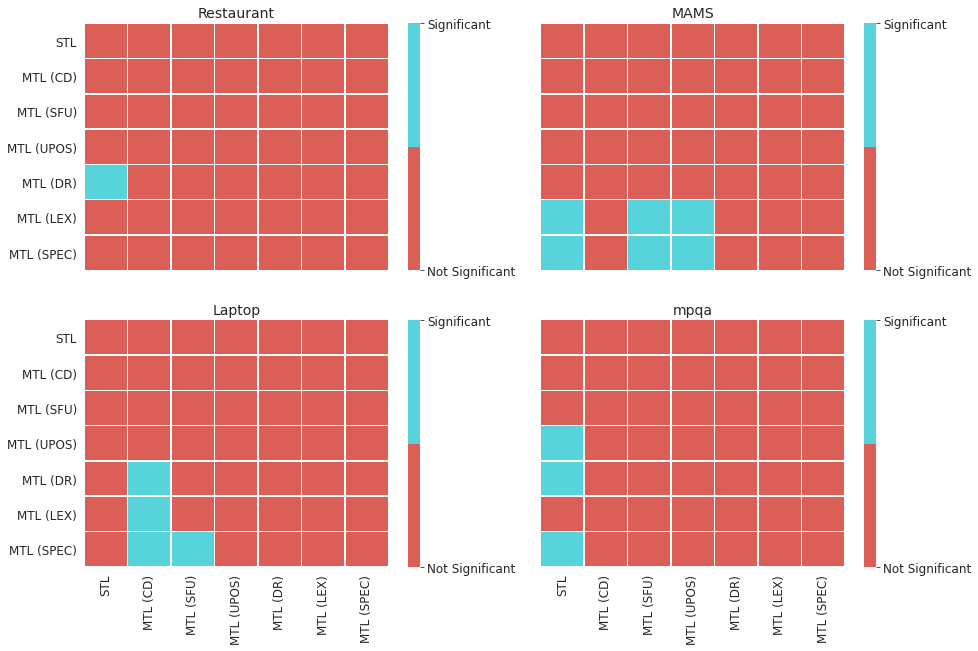

In [23]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-a')

Test:

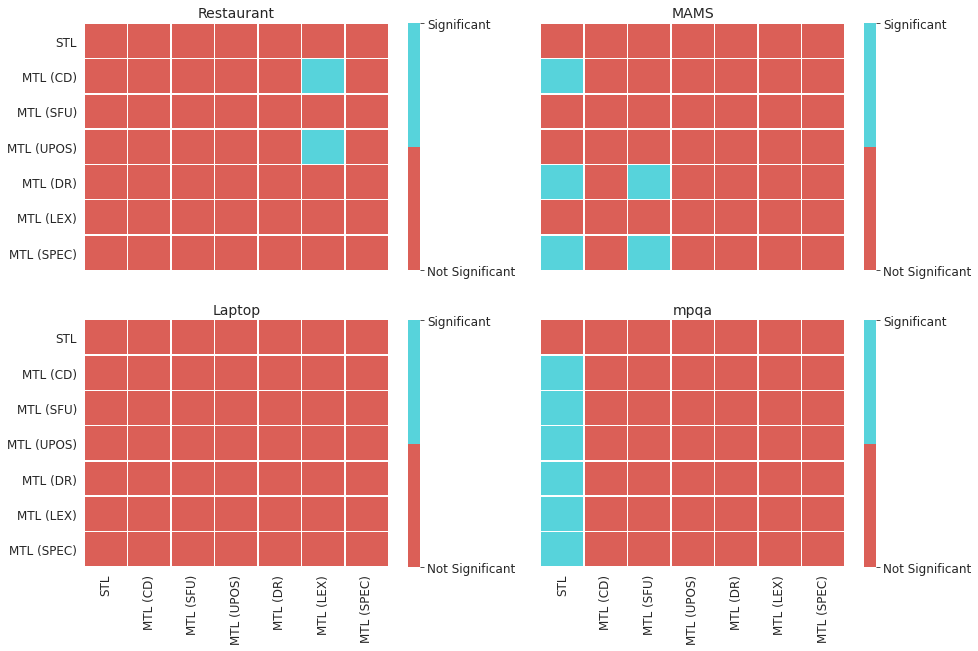

In [24]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-a')

### F1-s

Validation:

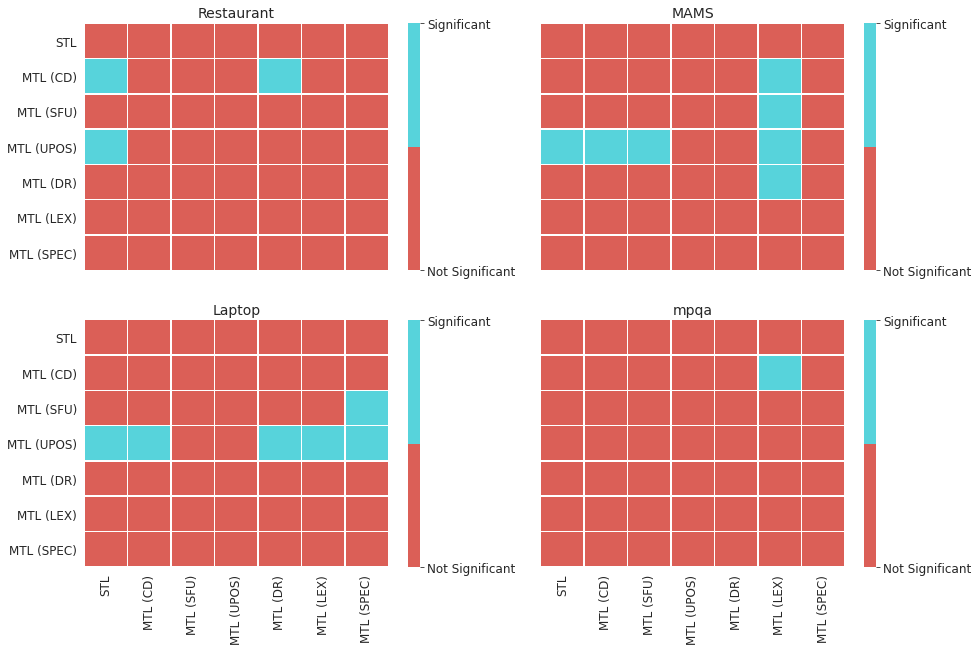

In [25]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-s')

Test:

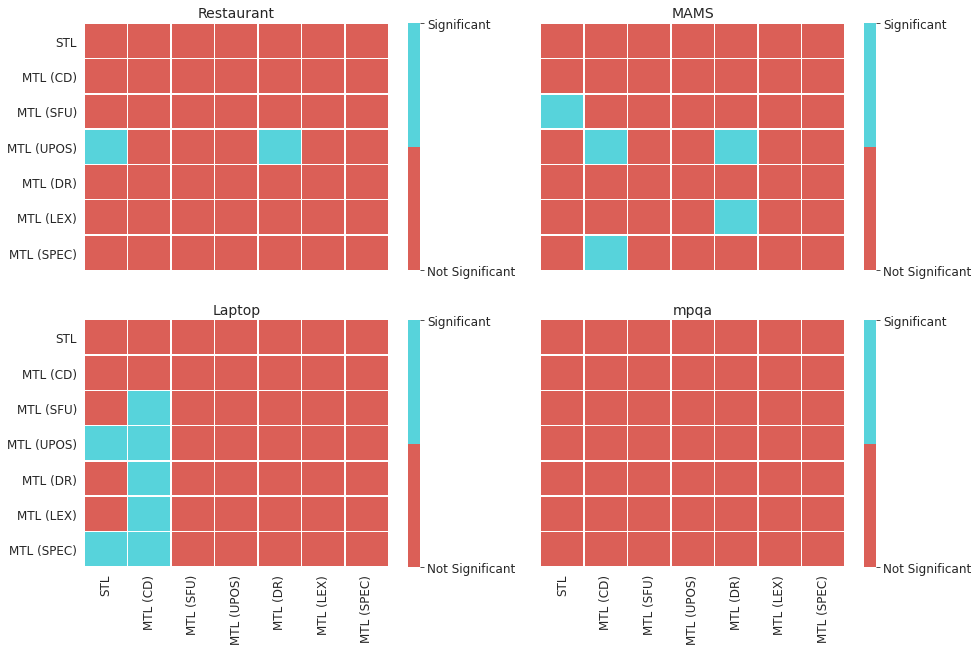

In [26]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-s')

### Acc-s

Validation:

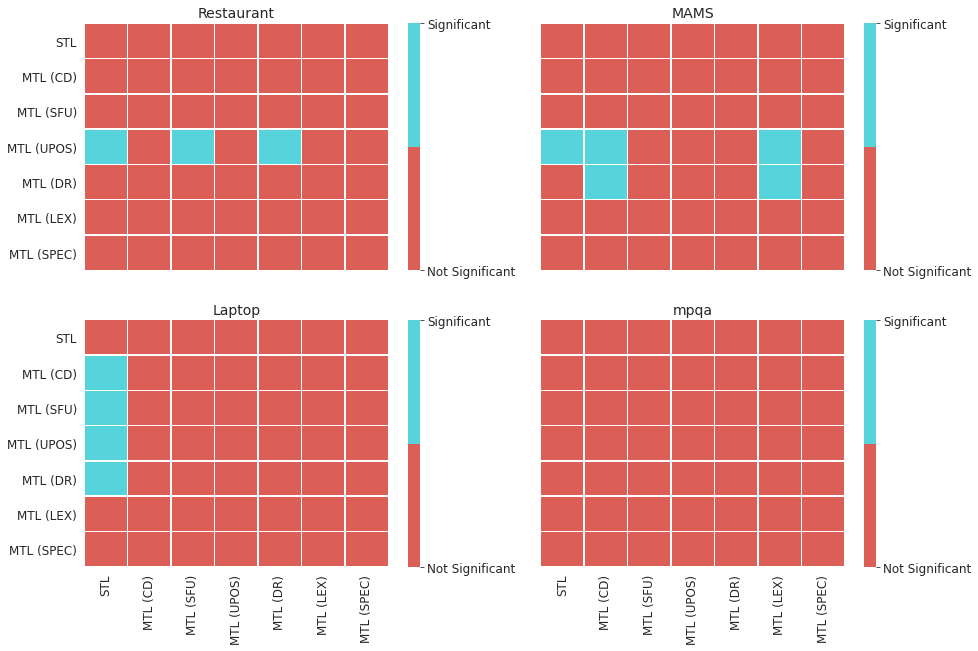

In [27]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='Acc-s')

Test:

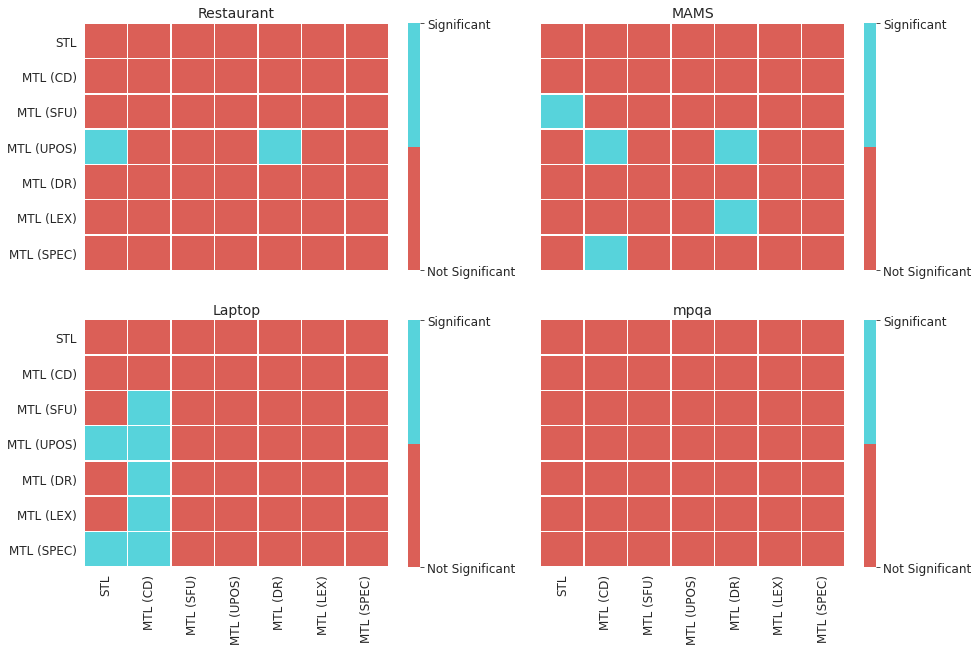

In [28]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-s')